# <center> Gender Biais detection</center>
## <center> What are the impact of the lematisation on biais detection </center>
### <center> Quillivic Robin </center>
Sources :Grammatical gender associations outweigh topical gender bias incross linguistic wordembeddings


In [1]:
from gensim import *
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
import logging
import gensim
import os

import itertools

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
from random import *

import pandas as pd
import numpy as np
import math

from sklearn.decomposition import PCA
import lib
import fasttext
from gensim.models.wrappers import FastText
import codecs

C:\Users\Robin\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Loading the French Model

In [6]:
# Logging code taken from http://rare-technologies.com/word2vec-tutorial/
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load pre-trained Word2Vec model.
#model  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\cc.fr.300.vec', binary=False,limit=50000)
model_lem  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\frWac_no_postag_no_phrase_500_skip_cut100.bin', binary=True)#,limit=50000)
#model  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\fr_Kyubyong_wordvectors.vec',binary=False,limit=50000)
model_wiki  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\wiki_fr.vec',binary=False,limit=50000)
model_wiki_lem  = gensim.models.KeyedVectors.load_word2vec_format('C:/Users/Robin/Documents/IMPACT/Notebooks/DATA/FR/ppmi_svd_fr/matrix.txt',binary=False,encoding='latin1')
# normalizeation :
model_lem.init_sims(True)
model_wiki.init_sims(True)
model_wiki_lem.init_sims(True)

2019-03-23 15:15:14,297 : INFO : loading projection weights from DATA\FR\frWac_no_postag_no_phrase_500_skip_cut100.bin
2019-03-23 15:15:16,121 : INFO : loaded (119227, 500) matrix from DATA\FR\frWac_no_postag_no_phrase_500_skip_cut100.bin
2019-03-23 15:15:16,152 : INFO : loading projection weights from DATA\FR\wiki_fr.vec
2019-03-23 15:15:28,687 : INFO : loaded (50000, 300) matrix from DATA\FR\wiki_fr.vec
2019-03-23 15:15:28,703 : INFO : loading projection weights from C:/Users/Robin/Documents/IMPACT/Notebooks/DATA/FR/ppmi_svd_fr/matrix.txt
2019-03-23 15:16:01,219 : INFO : loaded (53376, 500) matrix from C:/Users/Robin/Documents/IMPACT/Notebooks/DATA/FR/ppmi_svd_fr/matrix.txt
2019-03-23 15:16:01,235 : INFO : precomputing L2-norms of word weight vectors
2019-03-23 15:16:02,281 : INFO : precomputing L2-norms of word weight vectors
2019-03-23 15:16:02,687 : INFO : precomputing L2-norms of word weight vectors


## Loading the English Model

In [413]:
model_en = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\ENG\GoogleNews-vectors-negative300.bin', binary=True,limit=50000)
model_en_ff = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\ENG\crawl-300d-2M.vec', binary=False,limit=50000)
model_en_wiki = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\ENG\wiki.en.vec', binary=False,limit=50000)
# normalizeation :
model_en.init_sims(True)
model_en_ff.init_sims(True)

2019-03-26 09:11:05,131 : INFO : loading projection weights from DATA\ENG\GoogleNews-vectors-negative300.bin
2019-03-26 09:11:06,410 : INFO : loaded (50000, 300) matrix from DATA\ENG\GoogleNews-vectors-negative300.bin
2019-03-26 09:11:06,524 : INFO : loading projection weights from DATA\ENG\crawl-300d-2M.vec
2019-03-26 09:11:27,920 : INFO : loaded (50000, 300) matrix from DATA\ENG\crawl-300d-2M.vec
2019-03-26 09:11:28,030 : INFO : loading projection weights from DATA\ENG\wiki.en.vec
2019-03-26 09:11:48,449 : INFO : loaded (50000, 300) matrix from DATA\ENG\wiki.en.vec
2019-03-26 09:11:48,449 : INFO : precomputing L2-norms of word weight vectors
2019-03-26 09:11:49,149 : INFO : precomputing L2-norms of word weight vectors


## Build the list of test word

In the previous notebook we found that in the french model, grammatical gender chnage the represention andlake Biais decttection difficul. We suppose thta lemmatisation remove this difficulty. 
Now, We want to know if with we find the same kind of biais in lemmatised model than in english one. 
For this reason we create a set of test word where we know there is a Biais and evaluate the biais for each of this word in french and in english.

In [417]:
test_fr = [#profession
           'ingénieur','médecin', 'agriculteur','scientifique','avocat','politique','ministre',
           'banquier','sportif','dentiste', 'maçon',
           'secrétaire','infirmier', 'boulanger', 'journaliste', 'professeur','comptable','sage-femme',
           'vendeur','employé','ménage',
           # matière sholaire
           'mathématique', 'science','physique','informatique','finance','chimie','histoire','poésie','peinture',
           'art','danse','chant','littérature','gestion','production','économie','biologie','astronomie',
           'architecture','environnement', 'géographie','géométrie','musique','philosophie','religion','théâtre',
           #sport
           'football','basket','tennis','pétanque','ping-pong','escalade','course','saut',
           'natation','échec','jeu','poker', 'moto','vélo','cyclisme','kayak','surf','ski','athlétisme',
           'aviron','aviation','badminton','cirque','curling','catch','équitation','escrime','golf','judo',
           'musculation','polo','tango','voile','yoga',#'hand-ball'
            #vie quotidienne
            'cuisine','maison','jardin','magasin','shopping','sac','chaussure','sécurité','rock',
            'jupe','pantalon','argent','table','couteau','serviette','vin','bière']#'bricolage'

test_en =[#profession
           'engineer','doctor','farmer','scientist','lawyer','politician','minister',
           "banker", "sportsman", "dentist", "builder",
           'secretary','nurse','baker','journalist','teacher','accountant','midwife',
           "salesman", "employee", "cleaning",
           # sholar material
           'mathematics','science','physics','computer','finance','chemistry','history','poetry','painting',
           'art','dance','song','literature','management','production','economics','biology','astronomy',
           'architecture','environment','geography','geometry','music','philosophy','religion','theater',
           #sport
           'football','basketball','tennis','bowling','softball','climbing','running','jumping',
           'swimming','chess','play','poker','motorcycle','bicycle','cycling','kayaking','surfing','skiing','athletics',
           'rowing','aviation','badminton','circus','curling','wrestling','riding','fencing','golf','judo',
           "workout", "polo","tango", "veil", "yoga",#'hand-ball'
            #Daily life
            'kitchen','house','garden','shop','shopping','bag','shoe','security','rock',#'DIY'
            "skirt", "pants", "silver", "table", "knife", "towel", "wine", "beer"]



## Build the direction for each model language

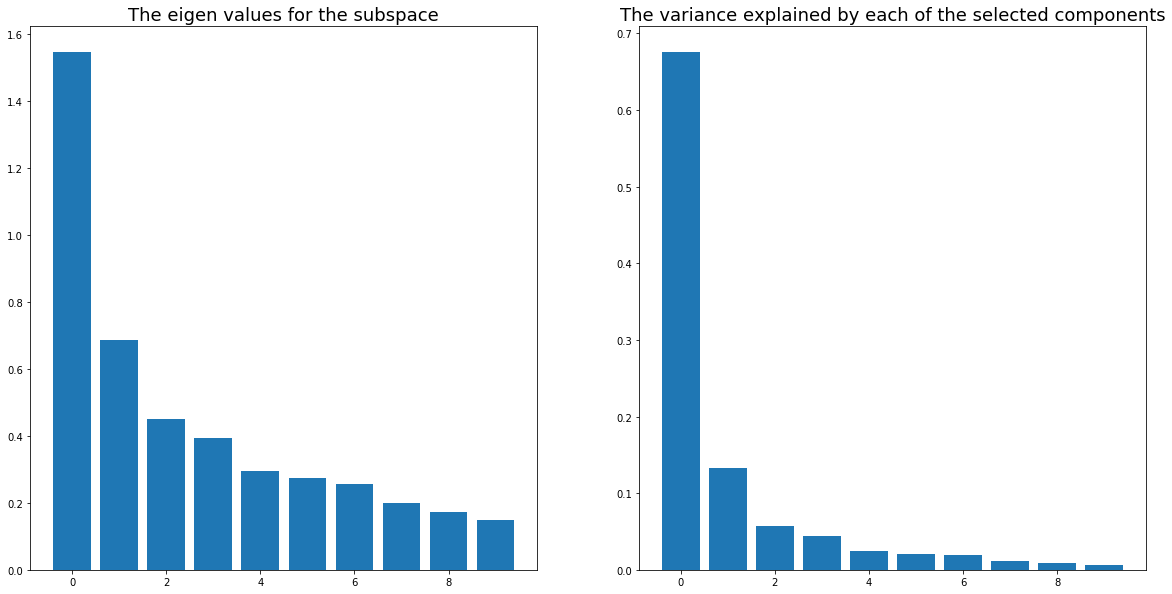

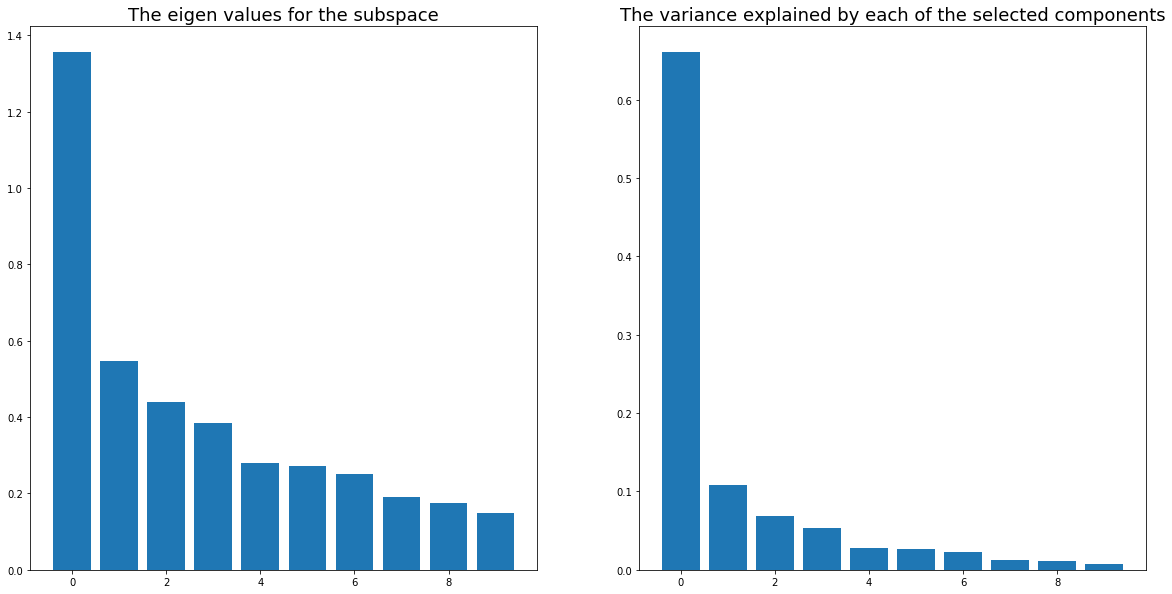

In [341]:
Pair_fr = [['elle','il'],['femme','homme'],['fille','garçon'],['mère','père'],['nièce','neveu'],
           ['fille','fil|fils'],['reine','roi'],['s\x9cur','frère'],['tante','oncle'],['maman','papa']]#
Pair_fr = [['petite-fille','petit-fils'],['femme','homme'],['fille','garçon'],['mère','père'],['nièce','neveu'],
           ['fille','fil|fils'],['reine','roi'],['s\x9cur','frère'],['tante','oncle'],['Marie','Louis']]#

direction_fr, expl_var_fr,eig_values_fr = lib.from_pair_to_direction2(Pair_fr, model_wiki_lem)

#############
Pair_en = [['she','he'],['woman','man'],['her','his'],['herself','himself'],['daughter','son'],
           ['mother','father'],['sister','brother'],['female','male'],['girl','boy'],['gal','guy']]

direction_en, expl_var_en,eig_values_en = lib.from_pair_to_direction2(Pair_en, model_en)
lib.plot_var_eig(eig_values_fr,expl_var_fr)
lib.plot_var_eig(eig_values_en,expl_var_en)
plt.show()

In [205]:
def from_pair_to_contribution(Pair, model):
    """
    Extraction of the contribution of each component for a pair of word in PCA
     Entry:
    - Pair: type:List  size:nx2 ; list of pair word
    - model: type:GensimModel
    Output:
    - direction : principal component of the PCA
    - expl_var : explained_variance_ratio_ of the pca
    - eig_values: eig_values of the pca
    """
    num_components = len(Pair)
    matrix = []
    label = []
    for a, b in Pair:
        center = (model[a] + model[b])/2
        matrix.append(model[a] - center)
        matrix.append(model[b] - center)
        label.append(str(a+'-'+b))
        label.append(str(b+'-'+a))
    
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    coord = pca.fit_transform(matrix)
    eigval = pca.singular_values_
    ctr = coord**2 
    contrib= pd.DataFrame(index=label)
    for j in range(num_components): 
        ctr[:,j] = ctr[:,j]/(eigval[j]) 
        contrib['CTR_'+str(j+1)] = ctr[:,j]
    return(contrib)

In [298]:
L = lib.association_Genrator('tante','oncle',model_wiki_lem,top_n=1000)


KeyboardInterrupt: 

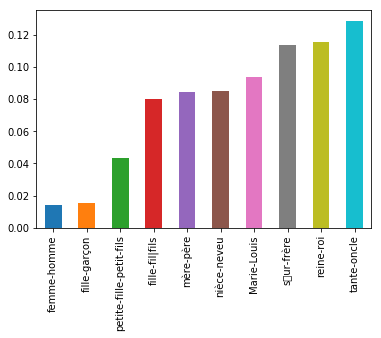

In [312]:
df_contrib = from_pair_to_contribution(Pair_fr, model_wiki_lem)
df = df_contrib.iloc[[2*i for i in range(10)],:].sort_values(by='CTR_1')
df['CTR_1'].plot(kind='bar')

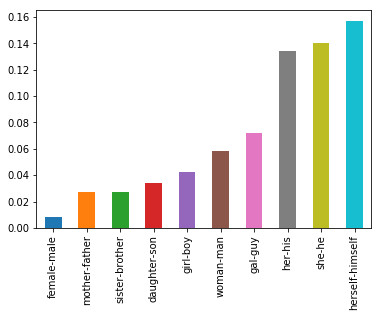

In [296]:
df_contrib = from_pair_to_contribution(Pair_en, model_en_ff)
df = df_contrib.iloc[[2*i for i in range(10)],:].sort_values(by='CTR_1')
df['CTR_1'].plot(kind='bar')

In [302]:
Biais_fr = []
Biais_en = []
for wf,we in zip(test_fr,test_en):
    Biais_fr.append(lib.cosine_similarity(model_wiki_lem[wf],direction_fr))
    Biais_en.append(lib.cosine_similarity(model_en[we],direction_en))
result = pd.DataFrame(data={'fr':Biais_fr,'en':Biais_en},index=test_fr)

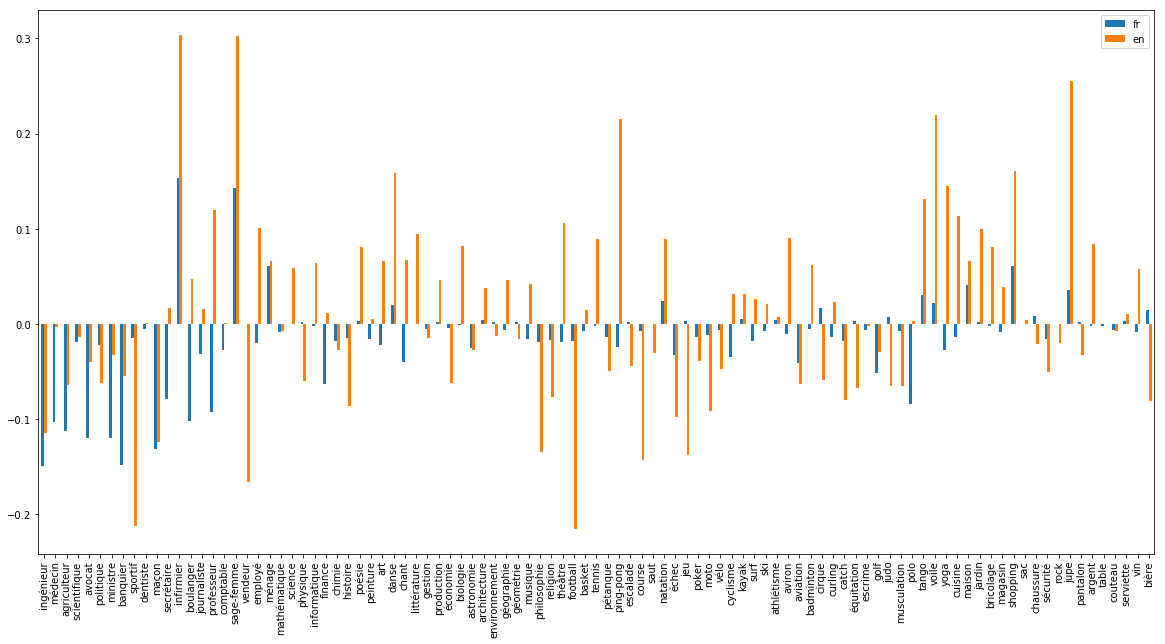

In [303]:
result.plot(kind='bar',figsize = (20,10))

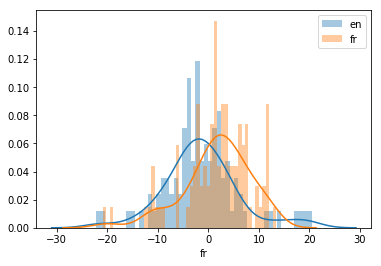

In [323]:
import seaborn as sns
sns.distplot(result['en'], bins=50, label = 'en',kde=True)
sns.distplot(result['fr'], bins=50, label = 'fr',kde=True)
plt.legend()
plt.show()
#result.plot(kind='hist',bins = 50,ax=plt.gca(),grid=True,alpha=0.5,kde=True)

In [225]:
result.describe()

,fr,en
count,100.000000,100.000000
mean,-0.009970,0.011072
std,0.034069,0.095346
min,-0.102856,-0.215074
25%,-0.025179,-0.050896
50%,-0.012330,0.002454
75%,0.012073,0.065940
max,0.075136,0.304010


In [257]:
result[(np.sign(result['en'])!=np.sign(result['fr']))]

,fr,en
dentiste,-0.004192,0.001286
secrétaire,-0.077823,0.017405
boulanger,-0.104932,0.047509
journaliste,-0.036608,0.016265
professeur,-0.092069,0.120145
comptable,-0.026212,0.000642
vendeur,0.000581,-0.166202
employé,-0.016032,0.100549
physique,0.004378,-0.059291
informatique,-0.003480,0.064195


In [389]:
def compute_error(Pair_fr,Pair_en,model_fr,model_en):
    direction_en, expl_var_en,eig_values_en = lib.from_pair_to_direction2(Pair_en, model_en)
    direction_fr, expl_var_fr,eig_values_fr = lib.from_pair_to_direction2(Pair_fr, model_fr)
    Biais_fr = []
    Biais_en = []
    for wf,we in zip(test_fr,test_en):
        Biais_fr.append(lib.cosine_similarity(model_fr[wf],direction_fr)*100)
        Biais_en.append(lib.cosine_similarity(model_en[we],direction_en)*100)
    
    result = pd.DataFrame(data={'fr':Biais_fr,'en':Biais_en},index=test_fr)
    print(len(result[np.sign(result['en'])==np.sign(result['fr'])])/len(result))
    return(result)

#Pair_fr = [['elle','il'],['femme','homme'],['fille','garçon'],['mère','père'],['fille','fils'],
             #['la','le'],['reine','roi'],['jument', 'cheval'],['soeur','frère'],['tante','oncle']]
result_bd = compute_error(Pair_fr,Pair_en,model_wiki_lem,model_en_ff)

0.6161616161616161


In [418]:
result_bd_wiki = compute_error(Pair_fr,Pair_en,model_wiki_lem,model_en_wiki)

0.5612244897959183


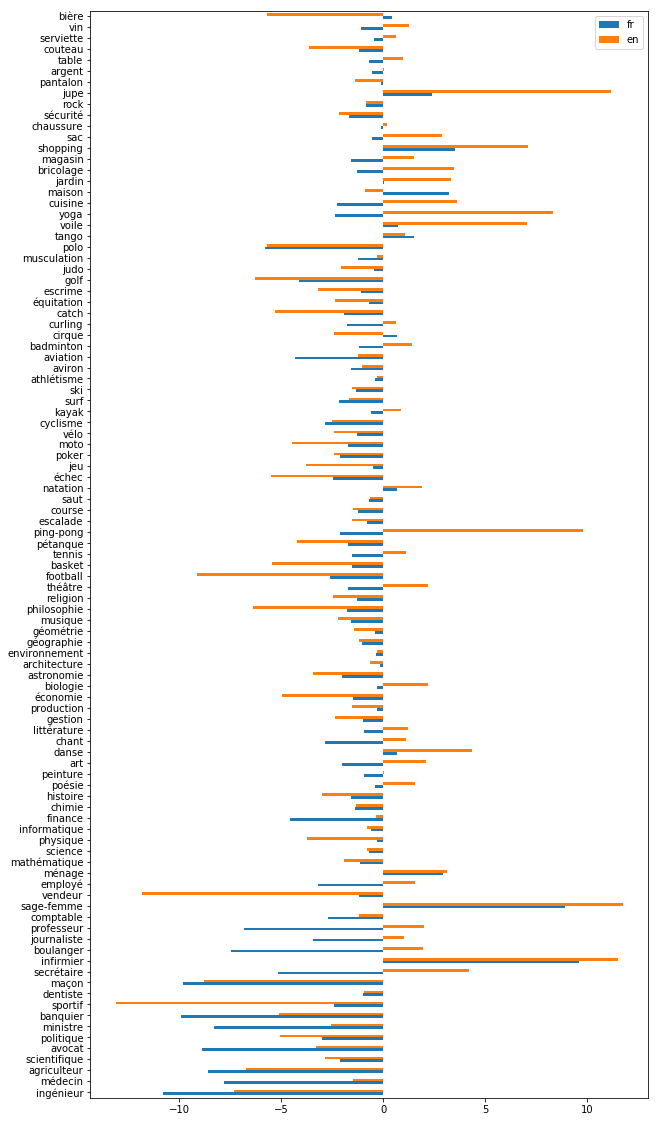

In [398]:
result=-result
result.plot(kind='barh',figsize = (10,20))
plt.savefig('all_dist_100_wefat.png')

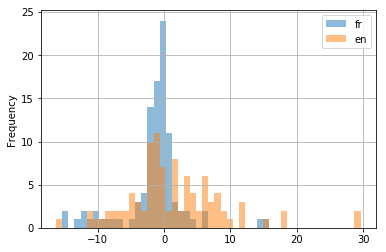

In [419]:
result_bd_wiki.plot(kind='hist',bins = 50,ax=plt.gca(),grid=True,alpha=0.5)

In [281]:
result

,fr,en
ingénieur,-15.101917,-13.204992
médecin,-9.833717,-2.048113
agriculteur,-11.125644,-11.482672
scientifique,-2.128866,-5.757140
avocat,-12.176149,-4.954153
politique,-2.446423,-8.848243
ministre,-12.590605,-5.130417
banquier,-15.582640,-8.591282
sportif,-1.446035,-22.185427
dentiste,-0.419151,-1.459419


In [420]:
def Direct_Biais(corpus, Pair, model):
    direction_g, expl_var_g,eig_values_g = lib.from_pair_to_direction2(Pair, model)
    B=[]
    for word in corpus :
        B.append(lib.cosine_similarity(direction_g,model[word]))
    df_B = pd.DataFrame(data={'Direct Biais':B})
    
    return(df_B,df_B['Direct Biais'].mean())
#
#Pair_fr = [['elle','il'],['femme','homme'],['fille','garçon'],['mère','père'],['femelle','mâle'],
#           ['la','le'],['reine','roi'],['jument', 'cheval'],['soeur','frère'],['tante','oncle']]

df_B_fr,m_fr  = Direct_Biais(list(model_en_wiki.vocab), Pair_en, model_en_wiki)
print('The direct biais od the 50000 word in the french corpus is ',m_fr)
df_B_en,m_en = Direct_Biais(list(model_en_ff.vocab), Pair_en, model_en_ff)
print('The direct biais od the 50000 word in the english corpus is ',m_en)

The direct biais od the 50000 word in the french corpus is  0.015144852274700533
The direct biais od the 50000 word in the english corpus is  -0.0044742344877576855


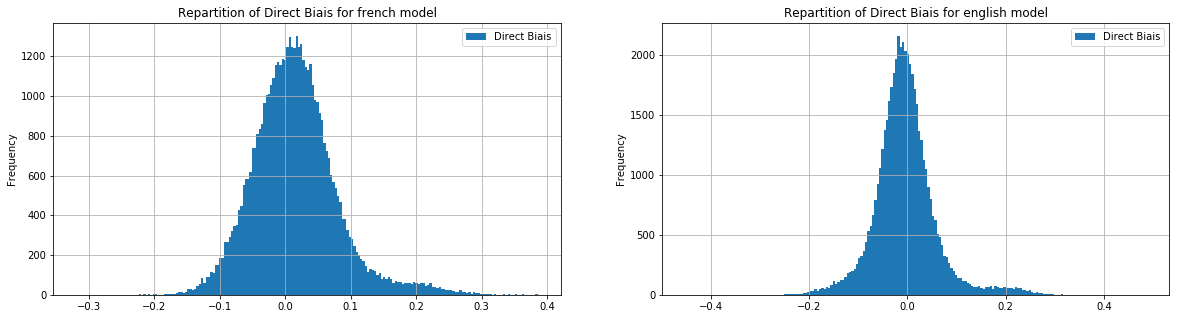

In [421]:
plt.figure(figsize=(20,5))
plt.subplot(121)
df_B_fr.plot(kind='hist',bins = 200,ax=plt.gca(),grid=True)
plt.title('Repartition of Direct Biais for french model')
plt.subplot(122)
df_B_en.plot(kind='hist',bins = 200,ax=plt.gca(),grid=True)
plt.title('Repartition of Direct Biais for english model')
plt.show()

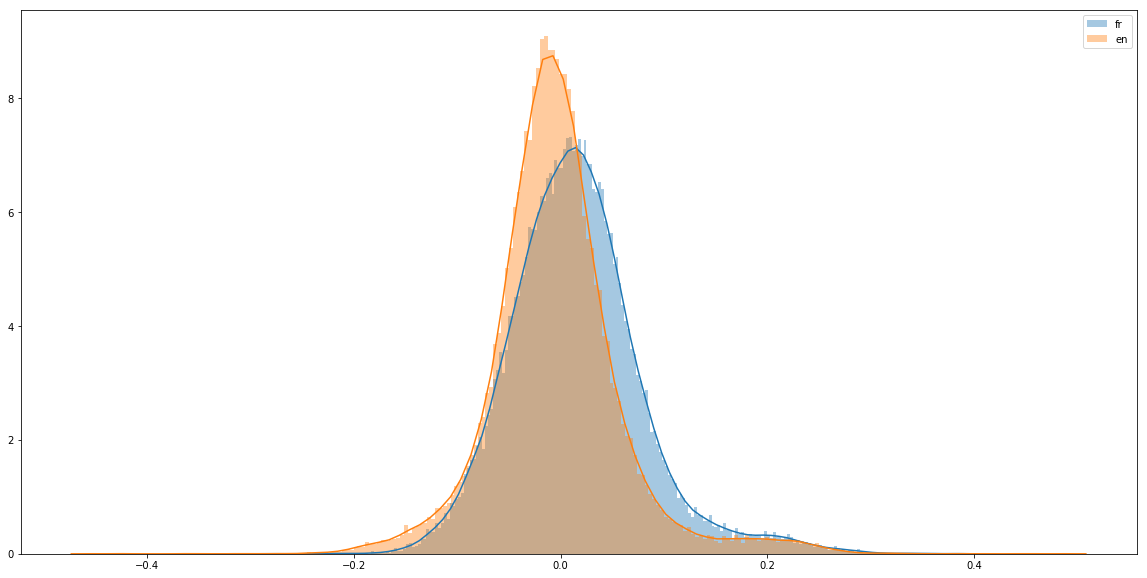

In [422]:
plt.figure(figsize=(20,10))
sns.distplot(df_B_fr, bins=250, label = 'fr',kde=True)
sns.distplot(df_B_en, bins=250, label = 'en',kde=True)
plt.legend()
plt.show()

In [185]:
import scipy
en =  list(df_B_en.values)
fr= list(df_B_fr.values)
z,p=scipy.stats.ranksums(en,fr)

In [186]:
z,p

(60.46741417700471, 0.0)

In [331]:
z,p=scipy.stats.ranksums(result['en'],result['fr'])
z,p

(-4.064202474579667, 4.819697446604094e-05)

In [332]:
from numpy import std, mean, sqrt
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return(mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)
print(cohen_d(result['en'],result['fr']))
print(cohen_d(en,fr))

-0.436607632687822
0.2982147268891815


# WEFAT



In [346]:
def from_pair_to_attribute(pair):
    A = []
    B = []
    for i in range(len(pair)):
        A.append(pair[i][1])
        B.append(pair[i][0])
    return([A,B])

att_fr = from_pair_to_attribute(Pair_fr)
att_en = from_pair_to_attribute(Pair_en)

In [385]:
def result(att_fr,att_en,model_fr,model_en):
    Biais_fr = []
    Biais_en = []
    for wf,we in zip(test_fr,test_en):
        Biais_fr.append((lib.s(wf,att_fr[0],att_fr[1],model_fr)+0.003)*100)
        Biais_en.append(lib.s(we,att_en[0],att_en[1],model_en)*100)
    
    result = pd.DataFrame(data={'fr':Biais_fr,'en':Biais_en},index=test_fr)
    print(len(result[np.sign(result['en'])==np.sign(result['fr'])])/len(result))
    return(result)

result = result(att_fr,att_en,model_wiki_lem,model_en_ff)

0.696969696969697


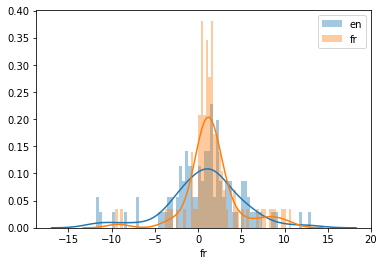

In [388]:
import seaborn as sns
sns.distplot(result['en'], bins=70, label = 'en',kde=True)
sns.distplot(result['fr'], bins=70, label = 'fr',kde=True)
plt.legend()
plt.show()

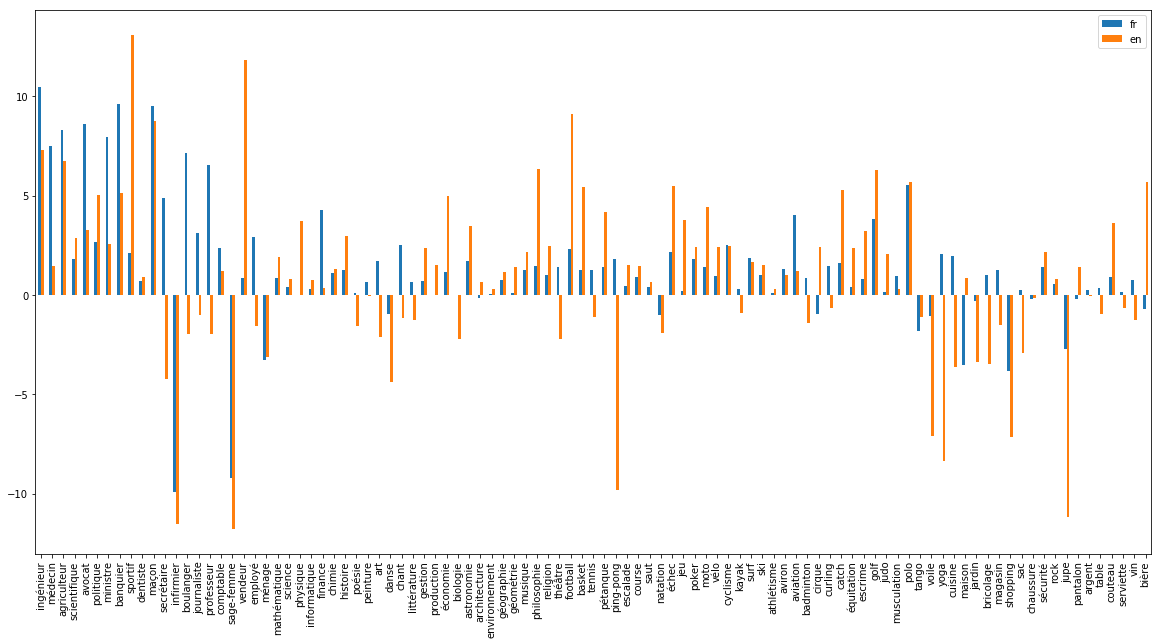

In [350]:
result.plot(kind='bar',figsize = (20,10))

In [352]:
-result

,fr,en
ingénieur,-10.496599,-7.292019
médecin,-7.515840,-1.459963
agriculteur,-8.303619,-6.729674
scientifique,-1.834142,-2.865345
avocat,-8.603837,-3.265357
politique,-2.674449,-5.042741
ministre,-7.980921,-2.565869
banquier,-9.625424,-5.116218
sportif,-2.092229,-13.108912
dentiste,-0.706403,-0.925478


In [368]:
-result[(np.sign(result['en'])!=np.sign(result['fr']))]

,fr,en
secrétaire,-4.875497,4.213884
boulanger,-7.144526,1.972618
journaliste,-3.134659,1.005381
professeur,-6.525178,1.985480
employé,-2.902588,1.576270
physique,0.000236,-3.726605
poésie,-0.078059,1.547720
peinture,-0.643594,0.041083
art,-1.731530,2.116745
chant,-2.525896,1.137007


In [403]:
final = pd.DataFrame(data = {'fr_db': result_bd['fr'].values,'en_db': result_bd['en'].values,'fr_wefat': result['fr'],'en_wefat': result['en']},index=test_fr)

In [412]:
final = final.apply(lambda x:round(x,2))
final.to_csv('final_biais.csv',encoding='latin1')